<a href="https://colab.research.google.com/github/kcat28/CCMACLRL_EXERCISES_COM221ML/blob/main/Exercise7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 7: Hate Speech Classification using Multinomial Naive Bayes

Instructions:
- You do not need to split your data. Use the training, validation and test sets provided below.
- Use Multinomial Naive Bayes to train a model that can classify if a sentence if a hate speech or not
- A sentence with a label of zero (0) is classified as non-hate speech
- A sentence with a label of one (1) is classified as a hate speech

Apply text pre-processing techniques such as
- Converting to lowercase
- Stop word Removal
- Removal of digits, special characters
- Stemming or Lemmatization but not both
- Count Vectorizer or TF-IDF Vectorizer but not both

Evaluate your model by:
- Providing input by yourself
- Creating a Confusion Matrix
- Calculating the Accuracy, Precision, Recall and F1-Score

In [429]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, precision_score, recall_score, accuracy_score, balanced_accuracy_score, ConfusionMatrixDisplay

In [430]:
splits = {'train': 'unique_train_dataset.csv', 'validation': 'unique_validation_dataset.csv', 'test': 'unique_test_dataset.csv'}

## Training Set

Use this to train your model

In [431]:
df_train = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["train"])

In [432]:
df_train.head()

,text,label
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1


In [433]:
df_train.isnull().sum()


,0
text,0
label,0


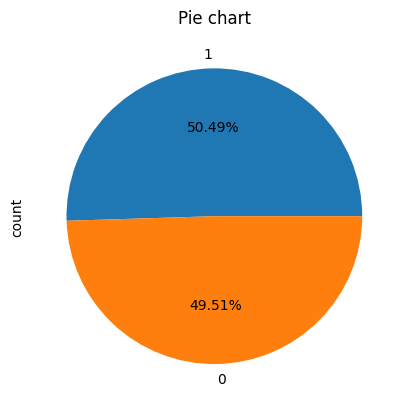

In [434]:
count.plot(kind = 'pie',autopct='%1.2f%%') # 1.2 is the decimal points for 2 places
plt.title('Pie chart')
plt.show()

In [435]:
df_train.rename(columns = {'text': 'message', 'label': 'class'}, inplace = True)

In [436]:
df_train.groupby('class').describe()

message                                                               
        count unique                                                top freq
class                                                                       
0       10779  10779                               [USERNAME] kakampink    1
1       10994  10994  Presidential candidate Mar Roxas implies that ...    1

In [437]:
filipino_words = [
    "akin", "aking", "ako", "alin", "am", "amin", "aming", "ang", "ano", "anumang",
    "apat", "at", "atin", "ating", "ay", "bababa", "bago", "bakit", "bawat", "bilang",
    "dahil", "dalawa", "dapat", "din", "dito", "doon", "gagawin", "gayunman", "ginagawa",
    "ginawa", "ginawang", "gumawa", "gusto", "habang", "hanggang", "hindi", "huwag", "iba",
    "ibaba", "ibabaw", "ibig", "ikaw", "ilagay", "ilalim", "ilan", "inyong", "isa", "isang",
    "itaas", "ito", "iyo", "iyon", "iyong", "ka", "kahit", "kailangan", "kailanman", "kami",
    "kanila", "kanilang", "kanino", "kanya", "kanyang", "kapag", "kapwa", "karamihan",
    "katiyakan", "katulad", "kaya", "kaysa", "ko", "kong", "kulang", "kumuha", "kung", "laban",
    "lahat", "lamang", "likod", "lima", "maaari", "maaaring", "maging", "mahusay", "makita",
    "marami", "marapat", "masyado", "may", "mayroon", "mga", "minsan", "mismo", "mula", "muli",
    "na", "nabanggit", "naging", "nagkaroon", "nais", "nakita", "namin", "napaka", "narito",
    "nasaan", "ng", "ngayon", "ni", "nila", "nilang", "nito", "niya", "niyang", "noon", "o",
    "pa", "paano", "pababa", "paggawa", "pagitan", "pagkakaroon", "pagkatapos", "palabas",
    "pamamagitan", "panahon", "pangalawa", "para", "paraan", "pareho", "pataas", "pero",
    "pumunta", "pumupunta", "sa", "saan", "sabi", "sabihin", "sarili", "sila", "sino", "siya",
    "tatlo", "tayo", "tulad", "tungkol", "una", "walang", "ata", "si", "mo", "eh", "e", "po", "ho"
]


In [438]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download("stopwords")
nltk.download('wordnet')
# nltk.download('punkt')

def clean_message(message):
    message = re.sub("[^A-Za-z]", " ", message) #1. Remove non-alphabetic characters
    message = message.lower() #2. Convert to lowercase
    message = message.split() #3. Split into words
    lemmatizer = WordNetLemmatizer() #4. Initialize lemmatizer

    # 5. Lemmatize and remove words found in filipino_words and stopwords
    message = [lemmatizer.lemmatize(word) for word in message if word not in set(filipino_words)]
    message = [lemmatizer.lemmatize(word) for word in message if word not in set(stopwords.words("english"))]

    message = " ".join(message) #6. Join the cleaned words into a single string
    return message


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [439]:
message = df_train.message[0]
print(message)

Presidential candidate Mar Roxas implies that the govt should not be liable re: Laglag Bala. Laglag Bayag na ata ito


In [440]:
message = clean_message(message)
print(message)

presidential candidate mar roxas implies govt liable laglag bala laglag bayag


In [441]:
messages = []
for i in range(0, len(df_train)):
    message = clean_message(df_train.message[i])
    messages.append(message)

In [442]:
df_train.head()

,message,class
0,Presidential candidate Mar Roxas implies that ...,1
1,Parang may mali na sumunod ang patalastas ng N...,1
2,Bet ko. Pula Ang Kulay Ng Posas,1
3,[USERNAME] kakampink,0
4,Bakit parang tahimik ang mga PINK about Doc Wi...,1


In [443]:
df_train = df_train.drop(["message"],axis=1)
df_train['messages'] = messages
df_train.head()

,class,messages
0,1,presidential candidate mar roxas implies govt ...
1,1,parang mali sumunod patalastas nescaf coffee b...
2,1,bet pula kulay posas
3,0,username kakampink
4,1,parang tahimik pink doc willie ong reaction paper


In [444]:
df_train.sample(20)

,class,messages
10146,1,grand theft coalition grand theft coalition ma...
13728,0,love pink feed let leni kiko lead let leni lead
6374,0,seri hill username username ok point lito atie...
4423,1,blengblong nyo tunay duwag let len lead
11862,1,mother asked year old daughter turning vote wo...
12437,0,gcash ga username let leni lead leni robredo
2825,1,binay president apec sure yung designer nancy ...
12053,0,username lang naman thought going sleep matata...
17819,0,username first place need know demand keep cha...
11056,0,username bka doc willie ong rin


In [445]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [446]:
tfidf_3 = TfidfVectorizer()
vectorized_data = tfidf_3.fit_transform(df_train['messages'])

In [447]:
from sklearn.naive_bayes import MultinomialNB
X = vectorized_data
y = df_train['class']
model = MultinomialNB(alpha=0.1)
model.fit(X, y)

MultinomialNB(alpha=0.1)

In [448]:
df_train.head()

,class,messages
0,1,presidential candidate mar roxas implies govt ...
1,1,parang mali sumunod patalastas nescaf coffee b...
2,1,bet pula kulay posas
3,0,username kakampink
4,1,parang tahimik pink doc willie ong reaction paper


## Validation Set

Use this set to evaluate your model

In [449]:
df_validation = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["validation"])

In [450]:
df_validation.head()

,text,label
0,VinTee [USERNAME] [USERNAME] and [USERNAME] Ka...,1
1,binay's sidekicks were employees of makati cit...,1
2,This is expected as we use different methodol...,0
3,Ang tanga tanga talaga ni Nancy Binay eh. Tskkk.,1
4,Binay giving away bracelets after every selfie...,0


In [451]:
predictions = model.predict(tfidf_3.transform(df_validation['text']))
accuracy = accuracy_score(df_validation['label'], predictions)
accuracy

0.8132142857142857

## Test Set

Use this set to test your model

In [452]:
df_test = pd.read_csv("hf://datasets/mapsoriano/2016_2022_hate_speech_filipino/" + splits["test"])

In [453]:
predictions = model.predict(tfidf_3.transform(df_test['text']))
accuracy = accuracy_score(df_test['label'], predictions)
accuracy

0.806049822064057

In [456]:
new_text = pd.Series("kingina mo ")
new_text_transform = tfidf_3.transform(new_text)
print(" The email is a" ,model.predict(new_text_transform))

 The email is a [1]
